### CTA Example Data Notebook

By S. Spencer 30/11/2022.

This notebook provides the essential data you need to be able to use the provided CTA data for your MoDAII project. The data is that from this paper: https://arxiv.org/abs/2103.06054, and consists of simulated corsika/sim_telarray event images for an array of four CTA CHEC-S/GCT telescopes at the CTA-South site in Cerro Paranal. Full QCD simulation for the protons and ray tracing simulation of the telescope optics, as well as simulation of the camera electronics and night sky background has already been performed. Your task is to use any machine learning method to separate the simulated gamma-ray events from the background events. Only a subset of the data will be provided initially, more is available if needed, as is GPU time if required.

The CHEC-S camera consists of 2048 pixels in a roughly square design, so the arrays provided already have square images already suitable for use for example with CNNs. However, there are uninstrumented regions in the camera corners that are zero padded. Events which only trigger e.g. 1 of the 4 telescopes are zero padded, such that the training arrays are of the shape n_events x 4 telescopes x (48x48) pixels.

There are two types of data in the files you should concern yourself with, timing histograms or charge data. If using the timing histograms these can be fed into a machine learning algorithm of choice as is, if using the charge data (actually the standard) these will need to be tailcut cleaned before processing using the *ctapipe* package available from here: https://github.com/cta-observatory/ctapipe/, but be aware you might need to use an older version of ctapipe for this to work with this data. 

Inside the data files (all ending in .hdf5), you'll find a number of structures. First to note is the event labels, which are the truth labels for the event classes. These are 0 for gamma-ray showers, 1 for protons and 2 for electrons (in equal ratios and already randomly mixed for training/test/validation purposes). I strongly suggest you perform array operations to remove these electron events from your training/test/validation data, essentially in the paper we tried to explore if electron event classification was possible and it turns out it isn't.

You are free to use any machine learning algorithm you wish to classify events, and can do this parametrically (by deriving Hillas parameters from the images using ctapipe) or using deep learning methods. If using deep learning I suggest you spend some time investigating the literature on the subject (such as Shilon et al. 2018 https://arxiv.org/abs/1803.10698, which kick-started the use of deep learning for IACT event classification). You can perform deep learning on individual IACT images (by downselecting to a single telescope and then removing the zero-padded images using numpy), or attempt the more challenging task of stereoscopic image analysis (the literature describes how to do this using a mixture of CNN/RNN methods, the *Keras* package API can help you to do this). What is not permitted is to add the individual IACT images together and then feed them into a DNN per-event, this is very bad and known not to work.

If investigating deep learning, you're unlikely to be able to fit the complete dataset into a GPU with a model at once. You'll need to investigate using data generators or tf.datasets to be able to train a network with sufficient data to get good results.

In [1]:
#!pip install tables 

In [2]:
#making the imports
import tables
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, utils
import keras
import numpy as np
import os
import pandas as pd
from datetime import datetime

In [3]:
hist_json_file = 'history_cnn.json'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)#Set the GPU for training
nepochs = 32#definine the number of epochs trained
np.random.seed(15234589)

In [4]:
class CNN(tf.keras.Model):#writing a class that inherits  from tf.keras.Model
    def __init__(self, dropoutRate = 0.4, input_shape = (4, 48, 48)):
        """
        Constructor for the CNN Model for binary classification.
        -----------
        Parameters:
            dropoutRate (float): The dropout rate for regularization (default=0.4)
            input_shape (tuple): The input shape of the data (default=(4, 48, 48))
        """
        super(CNN, self).__init__()
        #define the layers
        self.input_layer = layers.Input(input_shape)
        self.norm0 = layers.BatchNormalization()
        self.conf1 = layers.DepthwiseConv2D(5, depth_multiplier = 2, data_format='channels_first')
        self.relu1 = tf.keras.layers.LeakyReLU()
        self.norm1 = layers.BatchNormalization()
        self.drop1 = layers.Dropout(dropoutRate)
        
        self.conf2 = layers.DepthwiseConv2D(5, depth_multiplier = 2, data_format='channels_first')
        self.relu2 = tf.keras.layers.LeakyReLU()
        self.norm2 = layers.BatchNormalization()
        self.drop2 = layers.Dropout(dropoutRate)
        
        self.conf3 = layers.DepthwiseConv2D(5, depth_multiplier = 2, data_format='channels_first')
        self.relu3 = tf.keras.layers.LeakyReLU()
        self.norm3 = layers.BatchNormalization()
        self.drop3 = layers.Dropout(dropoutRate)
        
        self.conf4 = layers.DepthwiseConv2D(5, depth_multiplier = 2, data_format='channels_first')
        self.relu4 = tf.keras.layers.LeakyReLU()
        self.norm4 = layers.BatchNormalization()
        self.drop4 = layers.Dropout(dropoutRate)
        
        self.flat = layers.Flatten()
        self.fc1 = layers.Dense(1)
        self.out = self.call(self.input_layer)

    def call(self, inputs, training = True):
        """
        Define the forward pass of the CNN model.
        -----------
        Parameters:
            inputs (tf.Tensor): The input data
            training (bool): Whether or not the model is being called during training (default=True)
        ---------
        Returns:
            The output of the model
        """
        x = self.norm0(inputs,training)
        x = self.norm1(self.relu1(self.conf1(x)), training)
        x = self.drop1(x, training)
        x = self.norm2(self.relu2(self.conf2(x)), training)
        x = self.drop2(x, training)
        x = self.norm3(self.relu3(self.conf3(x)), training)
        x = self.drop3(x, training)
        x = self.norm4(self.relu4(self.conf4(x)), training)
        x = self.drop4(x, training)
        x = self.flat(x)
        return tf.math.sigmoid(self.fc1(x))
    
    def build_graph(self):
        """
        Builds a new `tf.keras.Model` instance with the current instance of `CNN` as the model definition.
        Just only for plotting reasons
        !!!doesnt work if the model was loaded!!!
        -----------
        Parameters:
            None
        -----------
        Returns:
            tf.keras.Model like the current instance
        """
        return tf.keras.Model(inputs=[self.input_layer], outputs=self.call(self.input_layer)) 

In [5]:
def data_reader(training_split = .3):
    """
    Reads data from HDF5 files in the current directory and returns three sets of data for training, testing,
    and validation.

    Args:
        training_split (float): The fraction of the data to be used for test and validation.

    Returns:
        A tuple containing:
            - A numpy array of training data.
            - A numpy array of training labels.
            - A numpy array of test data.
            - A numpy array of test labels.
            - A numpy array of validation data.
            - A numpy array of validation labels.
    """
    data, data_label = [], []
    data_length = 0
    for i in os.listdir():#list all files of the current folder
        if '.hdf5' in i:#check if this is a file of hd5f type
            x=tables.open_file(i,'r')
            data_label = np.concatenate((data_label, x.root.event_label[:])) #concatenate the labels
            data_length +=len(x.root.event_label[:])
            if len(data) != 0:#if one wats to concatenate(([], x.root.squared_training[:])) there will be an exception as the shape dirffers 
                data = np.concatenate((data, x.root.squared_training[:]), axis = 0)
            else:
                data = x.root.squared_training[:]
            x.close()#closing the files
            del x#garbage collecting
            
    mask = data_label[:] != 2#doing the trainingsplit
    data, data_label = data[mask], data_label[mask]        
    
    mask = training_split < np.random.rand(len(data_label))
    training, training_label = data[mask], data_label[mask]
    new_data, new_label = data[~mask], data_label[~mask]
    
    mask = .5 < np.random.rand(len(new_label))#doing the validation, test split
    test, test_label, val, val_label = new_data[mask], new_label[mask], new_data[~mask], new_label[~mask]
    
    del data, data_label, new_data, new_label#garbage collecting
    return training, training_label, test, test_label, val, val_label  

In [6]:
training, training_label, test, test_label, val, val_label  = data_reader()
#read the files
print(f"length of training data: {len(training_label)} with {np.sum(training_label):.0f} protons events")
print(f"length of test data: {len(test_label)} with {np.sum(test_label):.0f} protons events")
print(f"length of validation data: {len(val_label)} with {np.sum(val_label):.0f} protons events")

length of training data: 46574 with 23249 protons events
length of test data: 9974 with 4975 protons events
length of validation data: 10089 with 5101 protons events


In [7]:
try:#if there already exists a model, load this
    model = tf.keras.models.load_model('moda_network_cnn.tf')
    model.compile(optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy(),
                tf.keras.metrics.FalseNegatives(),
                tf.keras.metrics.FalsePositives()])
except OSError:#otherwise create a new and train it
    model = CNN()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy(),
                tf.keras.metrics.FalseNegatives(),
                tf.keras.metrics.FalsePositives()])

    history = model.fit(x = training, #train the model
                    y = training_label,
                    epochs=nepochs,
                    shuffle = True,#shuffls the data after each epoch
                    batch_size = 128,
                    validation_data = (val, val_label)
                    )
    hist_df = pd.DataFrame(history.history)  
    with open(hist_json_file, mode='w') as f:#save the history
        hist_df.to_json(f)
    history = history.history
    model.save('moda_network_cnn.tf')#save the model
    
history = pd.read_json(hist_json_file)#load the history, for easyer syntax in plots, woks when model is created as well as loaded       

Epoch 1/32
364/364 [==============================] - 18s 45ms/step - loss: 1.0546 - binary_accuracy: 0.5419 - false_negatives: 11100.0000 - false_positives: 10234.0000 - val_loss: 0.7702 - val_binary_accuracy: 0.5111 - val_false_negatives: 180.0000 - val_false_positives: 4753.0000
Epoch 2/32
364/364 [==============================] - 16s 43ms/step - loss: 0.8677 - binary_accuracy: 0.5905 - false_negatives: 9791.0000 - false_positives: 9283.0000 - val_loss: 0.6855 - val_binary_accuracy: 0.6956 - val_false_negatives: 252.0000 - val_false_positives: 2819.0000
Epoch 3/32
364/364 [==============================] - 16s 43ms/step - loss: 0.7626 - binary_accuracy: 0.6522 - false_negatives: 8264.0000 - false_positives: 7934.0000 - val_loss: 0.6139 - val_binary_accuracy: 0.8033 - val_false_negatives: 1557.0000 - val_false_positives: 428.0000
Epoch 4/32
364/364 [==============================] - 16s 43ms/step - loss: 0.6706 - binary_accuracy: 0.7069 - false_negatives: 6831.0000 - false_positives

INFO:tensorflow:Assets written to: moda_network_cnn.tf\assets


INFO:tensorflow:Assets written to: moda_network_cnn.tf\assets


In [8]:
model.evaluate(test, test_label)#evaluate the model

try:#model.build_graph() doesnt work if the model was loaded
    tf.keras.utils.plot_model(model.build_graph(), 'CNN.pdf', show_layer_names=False, expand_nested=True,show_shapes = True)
    model.summary()
except AttributeError:
    print('Graph plotting doesn\'t work if the model was loaded')
    

312/312 [==============================] - 2s 7ms/step - loss: 0.2761 - binary_accuracy: 0.9371 - false_negatives: 224.0000 - false_positives: 403.0000
Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 4, 48, 48)        192       
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 8, 44, 44)        208       
 Conv2D)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 44, 44)         0         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 44, 44)        176       
 hNormalization)                                                 
                                           

# Plots

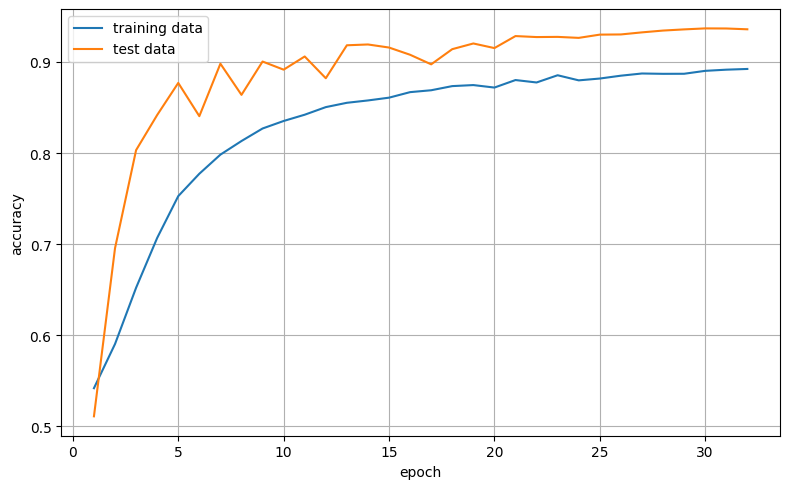

Best accuracy after 30 epochs


In [9]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.linspace(1,nepochs,nepochs), history['binary_accuracy'], label = 'training data')
ax.plot(np.linspace(1,nepochs,nepochs),history['val_binary_accuracy'], label = 'test data')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend()
ax.grid()
plt.tight_layout()
fig.savefig('model_accurancy_cnn.pdf')
plt.show()
print('Best accuracy after {} epochs'.format(np.argmax(history['val_binary_accuracy'])+1))

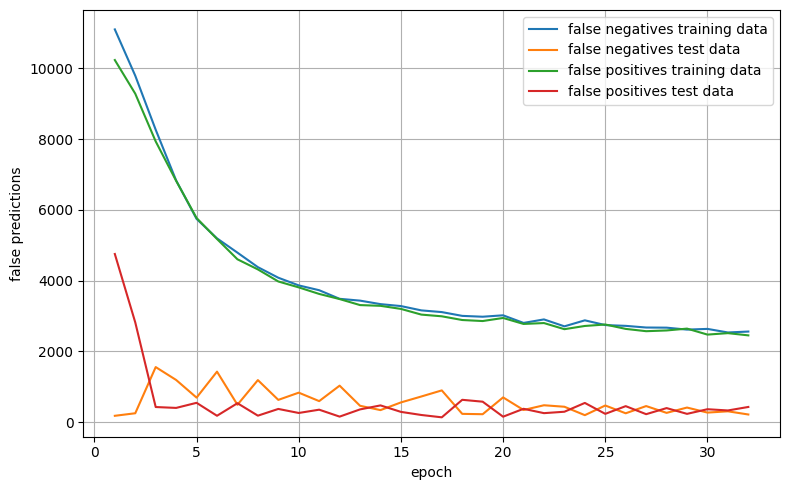

In [10]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.linspace(1,nepochs,nepochs),history['false_negatives'], label = 'false negatives training data')
ax.plot(np.linspace(1,nepochs,nepochs),history['val_false_negatives'], label = 'false negatives test data')
ax.plot(np.linspace(1,nepochs,nepochs),history['false_positives'], label = 'false positives training data')
ax.plot(np.linspace(1,nepochs,nepochs),history['val_false_positives'], label = 'false positives test data')
ax.set_ylabel('false predictions')
ax.set_xlabel('epoch')
ax.legend()
ax.grid()
plt.tight_layout()
fig.savefig('model_false_predition_cnn.pdf')
plt.show()

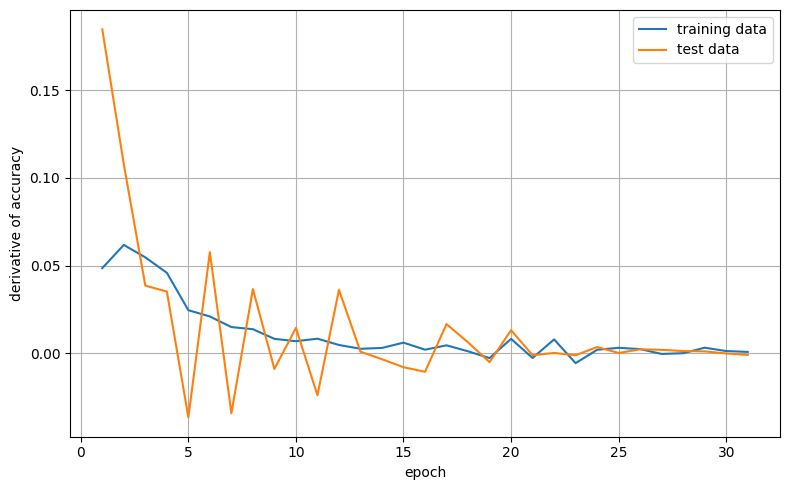

In [11]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.linspace(1,nepochs-1,nepochs-1),np.diff(history['binary_accuracy']), label = 'training data')
ax.plot(np.linspace(1,nepochs-1,nepochs-1),np.diff(history['val_binary_accuracy']), label = 'test data')
ax.set_ylabel('derivative of accuracy')
ax.set_xlabel('epoch')
ax.legend()
ax.grid()
plt.tight_layout()
fig.savefig('derivation_of_model_accurancy_cnn.pdf')
plt.show()

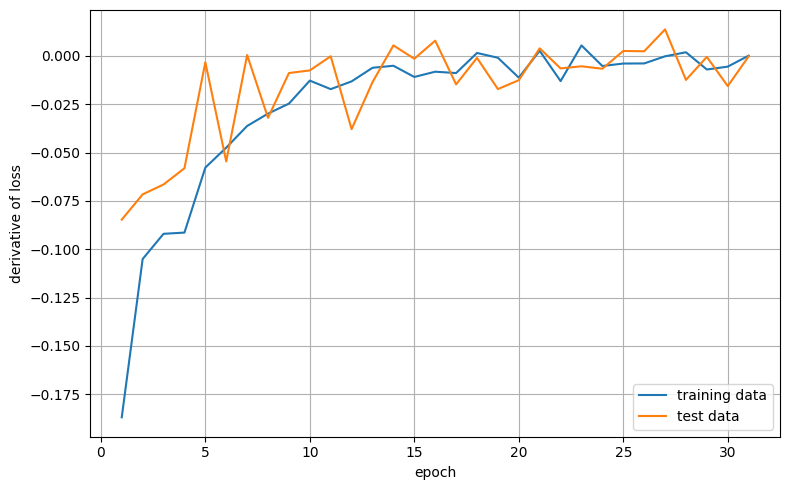

In [12]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.linspace(1,nepochs-1,nepochs-1),np.diff(history['loss']), label = 'training data')
ax.plot(np.linspace(1,nepochs-1,nepochs-1),np.diff(history['val_loss']), label = 'test data')
ax.set_ylabel('derivative of loss')
ax.set_xlabel('epoch')
ax.legend()
ax.grid()
plt.tight_layout()
fig.savefig('model_derivative_loss_cnn.pdf')
plt.show()


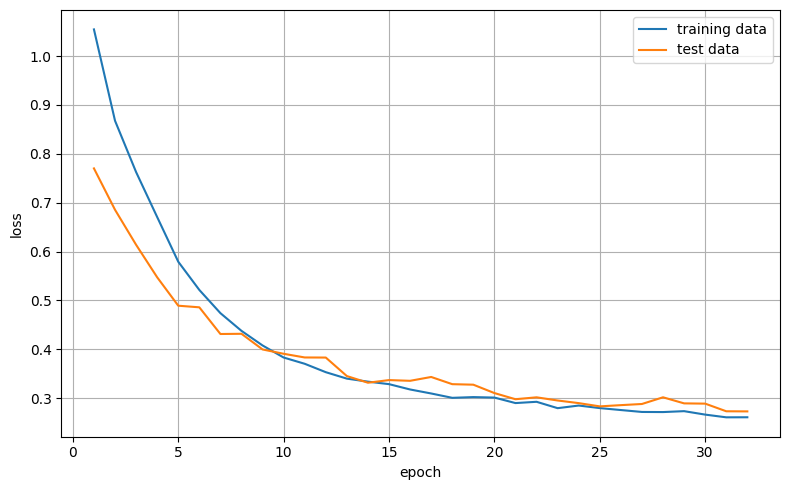

In [13]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.linspace(1,nepochs,nepochs),history['loss'], label = 'training data')
ax.plot(np.linspace(1,nepochs,nepochs),history['val_loss'], label = 'test data')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend()
ax.grid()
plt.tight_layout()
fig.savefig('model_loss_cnn.pdf')
plt.show()